Kaggle
# Titanic - Machine Learning from Disaster

In [487]:
import pandas as pd
import numpy as np

In [488]:
def import_file(filename):
    df = pd.read_csv(filename)
    return df

In [489]:
def fill_age(row, df):
    condition = ((df['Sex'] == row['Sex']) & (df['Pclass'] == row['Pclass']))
    return df[condition]['Age'].values[0]

In [490]:
def fill_fare(row, df):
    condition = ((df['Sex'] == row['Sex']) & (df['Pclass'] == row['Pclass']))
    return df[condition]['Fare'].values[0]

In [504]:
from collections import Counter
def clean_data(df):    
    # 687 rows have null entry for Cabin 
    # append column with first character from cabin as this may has some relevance e.g. which deck it's on (note that this doesn't take account of entries with more than one cabin)
    #df['Cabin'] = df['Cabin'].replace(np.nan, 'None')    
    df['CabinType'] = df['Cabin'].astype(str).str[0].str.upper()

    # 177 rows have null entry for Age
    # to populate the blanks, first determine the median entry by sex and class
    grouped_df = df.groupby(['Sex', 'Pclass'])
    grouped_df_median = grouped_df.median()
    grouped_df_median = grouped_df_median.reset_index()[['Sex', 'Pclass', 'Age']]
    df['Age'] = df.apply(lambda row: fill_age(row, grouped_df_median) if np.isnan(row['Age']) else row['Age'], axis = 1)

    # do the same for rows with blank Fare (there aren't any in the training data, but there are in the test data)
    grouped_df_median = grouped_df.median()
    grouped_df_median = grouped_df_median.reset_index()[['Sex', 'Pclass', 'Fare']]
    df['Fare'] = df.apply(lambda row: fill_fare(row, grouped_df_median) if np.isnan(row['Fare']) else row['Fare'], axis = 1)

    # 2 rows have null entry for Embarked
    # populate with the most frequent value
    lst = list(df['Embarked'])
    data = Counter(lst)
    most_common = max(lst, key=data.get)
    df.Embarked.fillna(most_common, inplace=True)

    # convert Pclass to a category field (for use in pd.get_dummies)
    df['Pclass'] = df['Pclass'].astype(str)

    # split age into bins
    age_bins = [ 0, 3, 10, 20, 30, 40, 50, 60, 70, np.inf ]
    age_bin_labels = ['Under 3', '3 to 10', '10 to 20', '20 to 30', '30 to 40', '40 to 50', '50 to 60', '60 to 70', 'Over 70']
    df['AgeRange'] = pd.cut(df['Age'], age_bins, labels=age_bin_labels)

    # Add SibSp and Parch to create Family column
    df['Family'] = df['SibSp'] + df['Parch']

    # split family size into bins (note that group size includes passenger so is one greater than family size)
    family_bins = [-1, 0, 3, np.inf]
    family_bin_labels = ['Solo', '2 to 4', '5+']
    df['GroupSize'] = pd.cut(df['Family'], family_bins, labels=family_bin_labels)

    ######################################################################################
    #
    # The following were suggestions by Ken Jee
    # https://www.youtube.com/watch?v=I3FBJdiExcg
    #
    ######################################################################################
    
    # where the cabin field has multiple entries, split and count the number of cabins
    # (note that the are also multiple rows sharing the same ticket number with multiple cabins, and multiple entries sharing the same cabin number(s) and multiple ticket numbers)
    df['NumCabins'] = df['Cabin'].apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))

    # identify ticket numbers that are entirely numeric
    df['NumericTickets'] = df['Ticket'].apply(lambda x: 1 if x.isnumeric() else 0)
    # identify the text portion (with punctuation removed) of non-numeric tickets
    df['TicketLetters'] = df['Ticket'].apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) > 0 else 0)

    # analysing the person's title - the name seems to have the format 'Surname, Title. Forenames'
    # group some of the infrequent titles together
    df['NameTitle'] = df.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
    dict_titles = { 'Mme':'Mrs', 'Mlle':'Miss', 'Ms':'Miss', 'Don':'Mr', 'Dr':'Working',
                    'Rev':'Working', 'Major':'Military', 'Col':'Military', 
                    'the Countess':'Titled', 'Sir':'Titled', 'Lady':'Titled', 
                    'Jonkheer':'Titled', 'Dona':'Mrs'}
    df['NameTitle'] = df.NameTitle.apply(lambda x: dict_titles[x] if x in dict_titles else x)

    # the log of Fare is more normal than Fare
    df['NormFare'] = np.log(df['Fare'] + 1)

    return df

In [492]:
def create_dummies(df):
    df_dummies = pd.get_dummies(df[['Age', 'SibSp', 'Parch', 'NormFare', 'Family', 
                                    'NumCabins', 'Pclass', 'Sex', 'Embarked', 'CabinType', 
                                    'AgeRange', 'GroupSize', 'NumericTickets', 
                                    'TicketLetters', 'NameTitle', 'TrainTest']])
    
    # Ken Jee's features
    # df_dummies = pd.get_dummies(df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'NormFare',      
    #                                 'Embarked', 'CabinType', 'NumCabins', 'NumericTickets', 
    #                                 'NameTitle', 'TrainTest']])
    return df_dummies

In [551]:
# suggestion from Ken Jee
# scale all numeric features (excluding Fare which has been replaced by NormFare)
from sklearn.preprocessing import StandardScaler
def scale_data(df):
    scale = StandardScaler()
    df_scaled = df.copy()
    col_list = ['Age', 'SibSp', 'Parch', 'Family', 'NumCabins', 'NormFare']
    df_scaled[col_list] = scale.fit_transform(df_scaled[col_list])
    return df_scaled

In [552]:
# import training data and append train/test flag column
filename = 'train.csv'
train_data = import_file(filename)
train_data['TrainTest'] = 1

# import test data and append Survived and train/test flag columns
filename = 'test.csv'
test_data = import_file(filename)
test_data['Survived'] = np.nan
test_data['TrainTest'] = 0

# concatenate the datasets
df_combined = pd.concat([train_data, test_data])

In [553]:
# prepare the data
df_combined = clean_data(df_combined)
df_dummies = create_dummies(df_combined)

In [554]:
# split the data back into train and test
X_train = df_dummies[df_dummies['TrainTest'] == 1]
y_train = df_combined['Survived'][df_combined['TrainTest'] == 1]
X_test = df_dummies[df_dummies['TrainTest'] == 0]

# scaled data
X_train_scaled = scale_data(X_train)
X_test_scaled = scale_data(X_test)

# Viewing the data

In [497]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   PassengerId     1309 non-null   int64   
 1   Survived        891 non-null    float64 
 2   Pclass          1309 non-null   object  
 3   Name            1309 non-null   object  
 4   Sex             1309 non-null   object  
 5   Age             1309 non-null   float64 
 6   SibSp           1309 non-null   int64   
 7   Parch           1309 non-null   int64   
 8   Ticket          1309 non-null   object  
 9   Fare            1309 non-null   float64 
 10  Cabin           295 non-null    object  
 11  Embarked        1309 non-null   object  
 12  TrainTest       1309 non-null   int64   
 13  CabinType       1309 non-null   object  
 14  AgeRange        1309 non-null   category
 15  Family          1309 non-null   int64   
 16  GroupSize       1309 non-null   category
 17  NumCabins      

In [498]:
df_combined.describe()

,PassengerId,Survived,Age,SibSp,Parch,Fare,TrainTest,Family,NumCabins,NumericTickets,NormFare
count,1309.000000,891.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,655.000000,0.383838,29.261398,0.498854,0.385027,33.276075,0.680672,0.883881,0.271963,0.731092,2.978804
std,378.020061,0.486592,13.218275,1.041658,0.865560,51.743642,0.466394,1.583639,0.574151,0.443561,0.968547
min,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,22.000000,0.000000,0.000000,7.895800,0.000000,0.000000,0.000000,0.000000,2.185579
50%,655.000000,0.000000,26.000000,0.000000,0.000000,14.454200,1.000000,0.000000,0.000000,1.000000,2.737881
75%,982.000000,1.000000,36.000000,1.000000,0.000000,31.275000,1.000000,1.000000,0.000000,1.000000,3.474293
max,1309.000000,1.000000,80.000000,8.000000,9.000000,512.329200,1.000000,10.000000,4.000000,1.000000,6.240917


In [499]:
df_combined.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,TrainTest,CabinType,AgeRange,Family,GroupSize,NumCabins,NumericTickets,TicketLetters,NameTitle,NormFare
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,1,N,20 to 30,1,2 to 4,0,0,a5,Mr,2.110213
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,1,C,30 to 40,1,2 to 4,1,0,pc,Mrs,4.280593
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,1,N,20 to 30,0,Solo,0,0,stono2,Miss,2.188856
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,1,C,30 to 40,1,2 to 4,1,1,0,Mrs,3.990834
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,1,N,30 to 40,0,Solo,0,1,0,Mr,2.202765


In [446]:
X_train.head()

,Age,SibSp,Parch,NormFare,Family,NumCabins,NumericTickets,Pclass_1,Pclass_2,Pclass_3,...,TicketLetters_wc,TicketLetters_wep,NameTitle_Capt,NameTitle_Master,NameTitle_Military,NameTitle_Miss,NameTitle_Mr,NameTitle_Mrs,NameTitle_Titled,NameTitle_Working
0,22.0,1,0,2.110213,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,38.0,1,0,4.280593,1,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,26.0,0,0,2.188856,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,35.0,1,0,3.990834,1,1,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,35.0,0,0,2.202765,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [526]:
y_train.head()

0    0.0
1    1.0
2    1.0
3    1.0
4    0.0
Name: Survived, dtype: float64

In [500]:
print(df_combined.NumCabins.value_counts())

0    1014
1     254
2      26
3      10
4       5
Name: NumCabins, dtype: int64


In [501]:
print(df_combined.CabinType.value_counts())

N    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: CabinType, dtype: int64


In [502]:
pd.pivot_table(df_combined, index='Survived', columns='CabinType', values='Name', aggfunc='count')

CabinType,A,B,C,D,E,F,G,N,T
Survived,,,,,,,,,
0.0,8.0,12.0,24.0,8.0,8.0,5.0,2.0,481.0,1.0
1.0,7.0,35.0,35.0,25.0,24.0,8.0,2.0,206.0,NaN


In [508]:
df_combined['NameTitle'].value_counts()

Mr          758
Miss        264
Mrs         199
Master       61
Working      16
Military      6
Titled        4
Capt          1
Name: NameTitle, dtype: int64

# Numerical Data

In [510]:
# numerical features
df_num = df_combined[['Age', 'SibSp', 'Parch', 'Fare', 'Family', 'NumCabins', 'NormFare']]

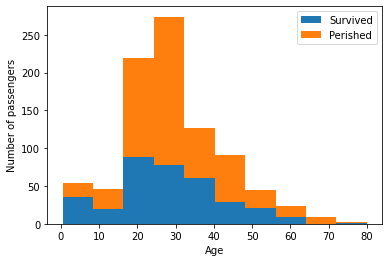

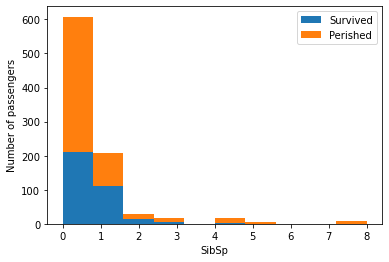

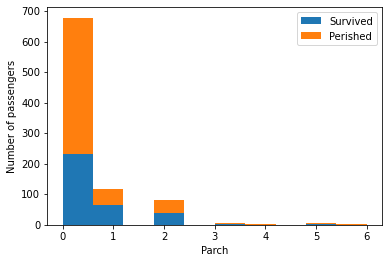

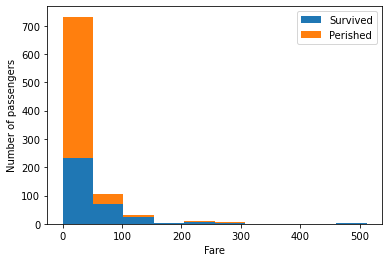

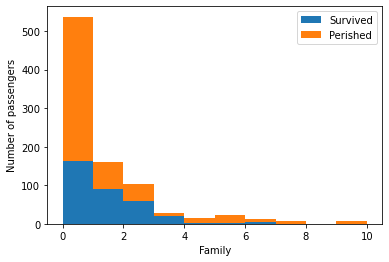

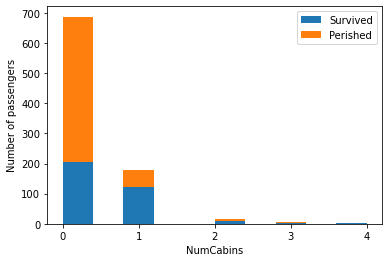

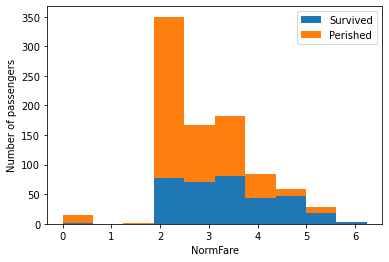

In [512]:
from matplotlib import pyplot as plt
import matplotlib.ticker
for feature in df_num:
    df_Survived = df_combined[df_combined['Survived'] == 1][feature]
    df_Perished = df_combined[df_combined['Survived'] == 0][feature]
    plt.hist([df_Survived, df_Perished],  stacked=True, label=['Survived', 'Perished'])
    plt.xlabel(feature)
    plt.ylabel('Number of passengers')
    plt.legend()
    if feature == 'NumCabins':
        locator = matplotlib.ticker.MultipleLocator(1)
        plt.gca().xaxis.set_major_locator(locator)
        formatter = matplotlib.ticker.StrMethodFormatter('{x:.0f}')
        plt.gca().xaxis.set_major_formatter(formatter)
    plt.show()

In [513]:
# correlations between numeric features
df_num.corr(method='pearson').round(3)

,Age,SibSp,Parch,Fare,Family,NumCabins,NormFare
Age,1.000,-0.204,-0.134,0.199,-0.208,0.255,0.212
SibSp,-0.204,1.000,0.374,0.160,0.862,0.039,0.312
Parch,-0.134,0.374,1.000,0.222,0.792,0.135,0.324
Fare,0.199,0.160,0.222,1.000,0.227,0.633,0.805
Family,-0.208,0.862,0.792,0.227,1.000,0.100,0.382
NumCabins,0.255,0.039,0.135,0.633,0.100,1.000,0.569
NormFare,0.212,0.312,0.324,0.805,0.382,0.569,1.000


In [514]:
# normality tests
def normal_tests(x):
    from scipy.stats import shapiro
    from scipy.stats import normaltest
    from scipy.stats import anderson
    alpha = 0.05

    # shapiro wilk test
    W, p_value = shapiro(x)
    if p_value > alpha:
        print('Shapiro Wilk: Sample looks Gaussian (fail to reject H0)', p_value)
    else:
        print('Shapiro Wilk: Sample does not look Gaussian (reject H0)', p_value)

    # d'agostino test
    stat, p_value = normaltest(x)
    if p_value > alpha:
        print("D'Agostino: Sample looks Gaussian (fail to reject H0)", p_value)
    else:
        print("D'Agostino: Sample does not look Gaussian (reject H0)", p_value)

    # anderson test
    result = anderson(x)
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < result.critical_values[i]:
            print('Anderson: data looks Gaussian at significance level', sl, '(fail to reject H0)')
        else:
            print('Anderson: data does not look Gaussian at significance level', sl, '(reject H0)')

Age
Lambda value used for transformation: 0.7386020236286714


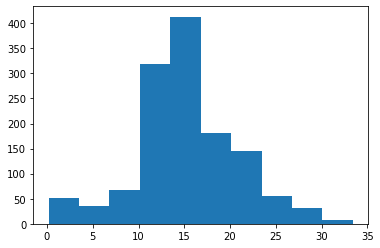

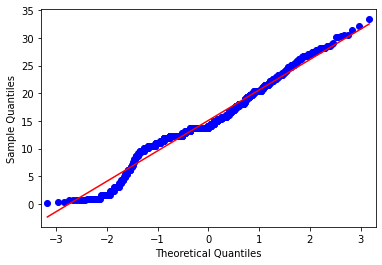

Shapiro Wilk: Sample does not look Gaussian (reject H0) 3.8840703737279823e-16
D'Agostino: Sample does not look Gaussian (reject H0) 0.000346453229788504
Anderson: data does not look Gaussian at significance level 15.0 (reject H0)
Anderson: data does not look Gaussian at significance level 10.0 (reject H0)
Anderson: data does not look Gaussian at significance level 5.0 (reject H0)
Anderson: data does not look Gaussian at significance level 2.5 (reject H0)
Anderson: data does not look Gaussian at significance level 1.0 (reject H0)

SibSp
Lambda value used for transformation: -2.6181831095579122


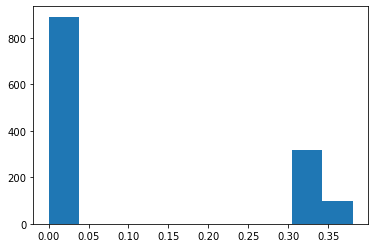

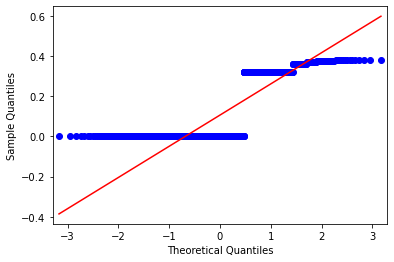

Shapiro Wilk: Sample does not look Gaussian (reject H0) 0.0
D'Agostino: Sample does not look Gaussian (reject H0) 0.0
Anderson: data does not look Gaussian at significance level 15.0 (reject H0)
Anderson: data does not look Gaussian at significance level 10.0 (reject H0)
Anderson: data does not look Gaussian at significance level 5.0 (reject H0)
Anderson: data does not look Gaussian at significance level 2.5 (reject H0)
Anderson: data does not look Gaussian at significance level 1.0 (reject H0)

Parch
Lambda value used for transformation: -4.12540217983754


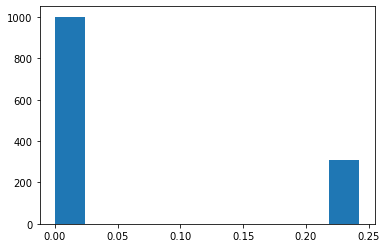

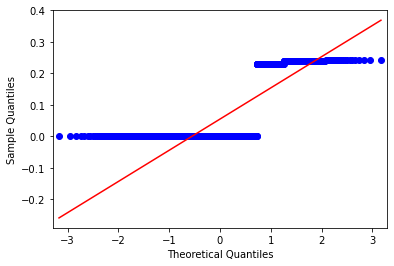

Shapiro Wilk: Sample does not look Gaussian (reject H0) 0.0
D'Agostino: Sample does not look Gaussian (reject H0) 2.0380537162560426e-51
Anderson: data does not look Gaussian at significance level 15.0 (reject H0)
Anderson: data does not look Gaussian at significance level 10.0 (reject H0)
Anderson: data does not look Gaussian at significance level 5.0 (reject H0)
Anderson: data does not look Gaussian at significance level 2.5 (reject H0)
Anderson: data does not look Gaussian at significance level 1.0 (reject H0)

Fare
Lambda value used for transformation: -0.14162329992367895


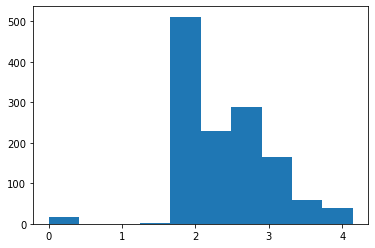

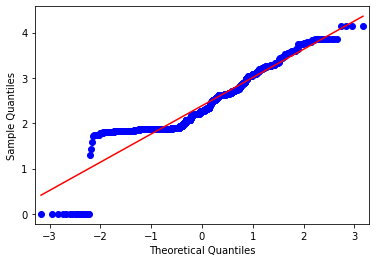

Shapiro Wilk: Sample does not look Gaussian (reject H0) 1.719602758329098e-27
D'Agostino: Sample does not look Gaussian (reject H0) 3.721362228433548e-12
Anderson: data does not look Gaussian at significance level 15.0 (reject H0)
Anderson: data does not look Gaussian at significance level 10.0 (reject H0)
Anderson: data does not look Gaussian at significance level 5.0 (reject H0)
Anderson: data does not look Gaussian at significance level 2.5 (reject H0)
Anderson: data does not look Gaussian at significance level 1.0 (reject H0)

Family
Lambda value used for transformation: -1.4618478465764266


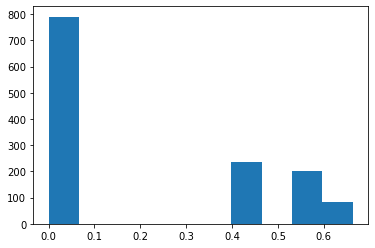

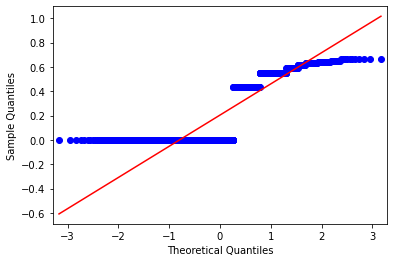

Shapiro Wilk: Sample does not look Gaussian (reject H0) 2.2560905275629555e-43
D'Agostino: Sample does not look Gaussian (reject H0) 0.0
Anderson: data does not look Gaussian at significance level 15.0 (reject H0)
Anderson: data does not look Gaussian at significance level 10.0 (reject H0)
Anderson: data does not look Gaussian at significance level 5.0 (reject H0)
Anderson: data does not look Gaussian at significance level 2.5 (reject H0)
Anderson: data does not look Gaussian at significance level 1.0 (reject H0)

NumCabins
Lambda value used for transformation: -5.294194073515857


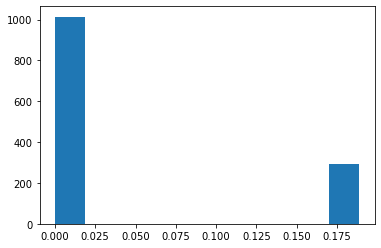

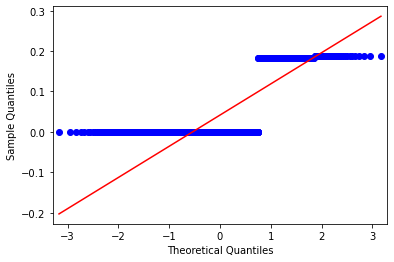

Shapiro Wilk: Sample does not look Gaussian (reject H0) 0.0
D'Agostino: Sample does not look Gaussian (reject H0) 2.371241296957426e-52
Anderson: data does not look Gaussian at significance level 15.0 (reject H0)
Anderson: data does not look Gaussian at significance level 10.0 (reject H0)
Anderson: data does not look Gaussian at significance level 5.0 (reject H0)
Anderson: data does not look Gaussian at significance level 2.5 (reject H0)
Anderson: data does not look Gaussian at significance level 1.0 (reject H0)



In [515]:
# can any data be normalised?
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import yeojohnson
for feature in df_num:
    if feature != 'NormFare':
        print(feature)
        fitted_data, best_lambda = yeojohnson(df_num[feature])
        print('Lambda value used for transformation:', best_lambda)
        plt.hist(fitted_data)
        plt.show()
        qqplot(fitted_data, line='s')
        plt.show()
        normal_tests(fitted_data)
        print()

Age


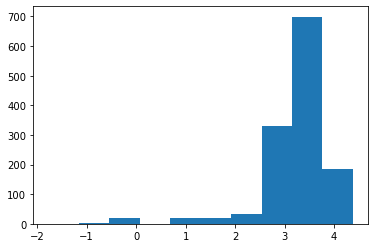

SibSp


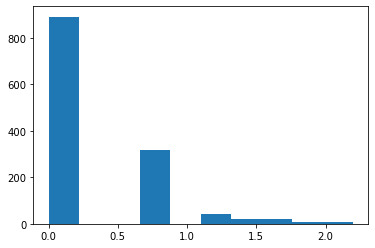

Parch


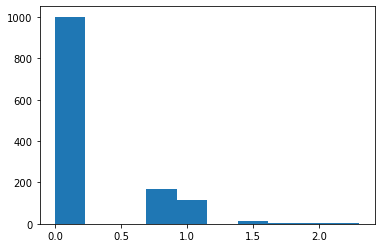

Fare


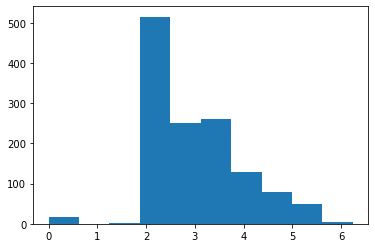

Family


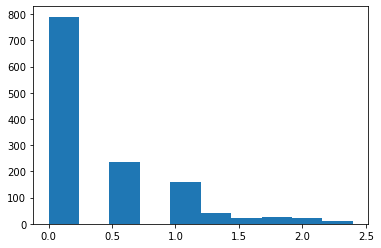

NumCabins


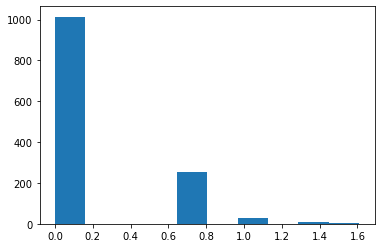

NormFare


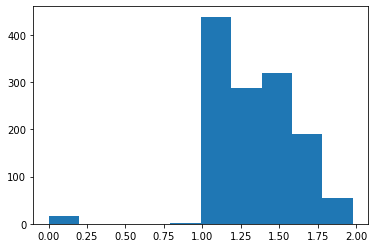

In [516]:
# plot log norm for all numeric fields (suggested by Ken Jee)
# this is similar to my Yeo Johnson normalisation above
for feature in df_num:
    print(feature)
    addition = 0
    if min(df_num[feature]) == 0:
        addition = 1
    norm = np.log(df_num[feature]+addition)
    plt.hist(norm)
    plt.show()

# Categorical Data

In [517]:
# categorical features
df_cat = df_combined[['Survived', 'Pclass', 'Sex', 'Embarked', 'CabinType', 'AgeRange', 'GroupSize', 'NumericTickets', 'TicketLetters', 'NameTitle']]

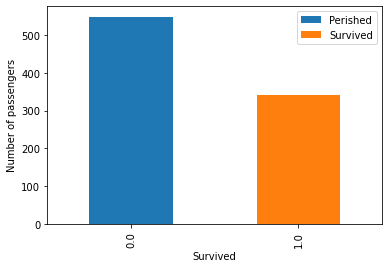

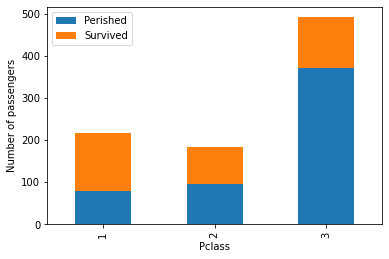

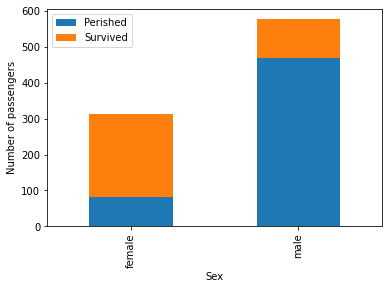

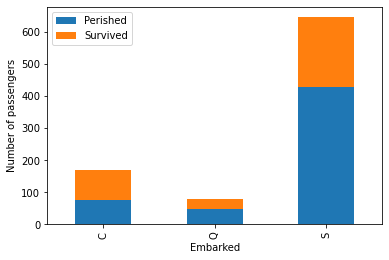

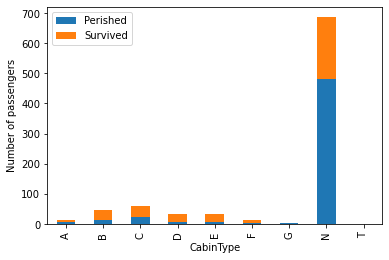

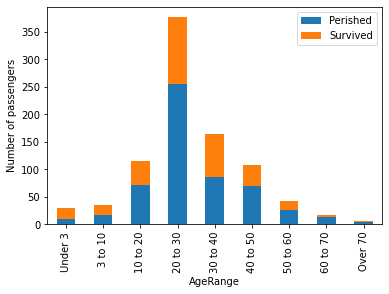

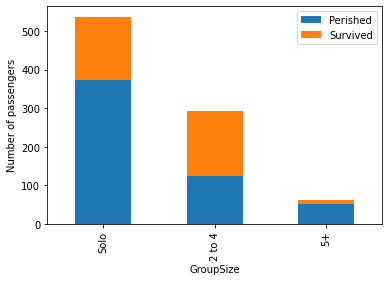

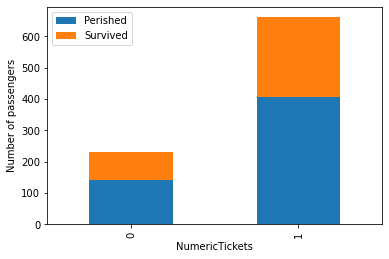

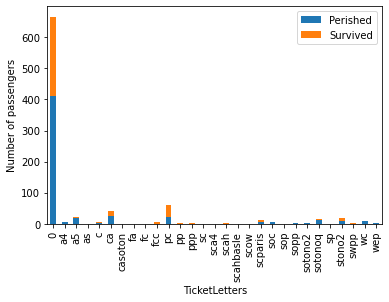

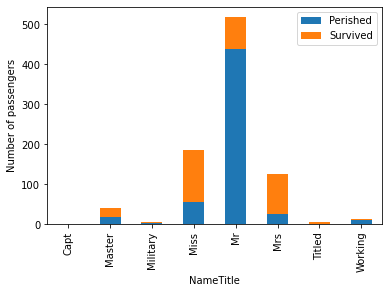

In [518]:
from matplotlib import pyplot as plt
for feature in df_cat:
    df_combined.groupby([feature, 'Survived']).size().unstack().plot(kind='bar', stacked=True)
    plt.xlabel(feature)
    plt.ylabel('Number of passengers')
    plt.legend(['Perished', 'Survived'])
    plt.show()

In [519]:
# independence of observations from two categorical features
from scipy.stats import chi2_contingency
from scipy.stats import chi2

def check_independence(df, var1, var2):
    contingency_table = pd.crosstab(df[var1], df[var2], margins = False) 
    print(contingency_table) 

    # implement the Pearson's Chi-Squared test for independence
    stat, p, dof, expected = chi2_contingency(contingency_table)

    # interpret test-statistic
    prob = 0.95
    critical = chi2.ppf(prob, dof)
    if abs(stat) >= critical:
        print('Test statistic indicates: Dependent (reject H0)')
    else:
        print('Test statistic indicates: Independent (fail to reject H0)')

    # interpret p-value
    alpha = 1.0 - prob
    if p <= alpha:
        print('p-value indicates: Dependent (reject H0)')
    else:
        print('p-value indicates: Independent (fail to reject H0)')
    print()

In [520]:
for field in df_cat:
    if field != 'Survived':
        check_independence(df_combined, 'Survived', field)

Pclass      1   2    3
Survived              
0.0        80  97  372
1.0       136  87  119
Test statistic indicates: Dependent (reject H0)
p-value indicates: Dependent (reject H0)

Sex       female  male
Survived              
0.0           81   468
1.0          233   109
Test statistic indicates: Dependent (reject H0)
p-value indicates: Dependent (reject H0)

Embarked   C   Q    S
Survived             
0.0       75  47  427
1.0       93  30  219
Test statistic indicates: Dependent (reject H0)
p-value indicates: Dependent (reject H0)

CabinType  A   B   C   D   E  F  G    N  T
Survived                                  
0.0        8  12  24   8   8  5  2  481  1
1.0        7  35  35  25  24  8  2  206  0
Test statistic indicates: Dependent (reject H0)
p-value indicates: Dependent (reject H0)

AgeRange  Under 3  3 to 10  10 to 20  20 to 30  30 to 40  40 to 50  50 to 60  \
Survived                                                                       
0.0            10       16        71

# Model Building (Baseline Validation Performance)

Ken Jee first investigated how various different models performed with default parameters.  He tried the following models using 5 fold cross validation to get a baseline.  Once a baseline has been obtained, we can see how much tuning improves each of the models:
- Naive Bayes (72.6%)
- Logistic Regression (82.1%)
- Decision Tree (77.6%)
- K Nearest Neighbor (80.5%)
- Random Forest (80.6%)
- Support Vector Classifier (83.2%) - this is the highest scoring model
- Xtreme Gradient Boosting (81.8%)
- Soft Voting Classificer - All Models (82.8%)

Note that just because a model has a high baseline on the validation set, it doesn't mean that it will do better on the eventual test set

One obvious difference between my data and Ken Jee's is the way null values have been dealt with:
- he removed rows with null Embarked, whereas I populated with most common value
- he populated null Age with mean Age whereas I used median based on Sex and Pclass
- he populated null Fare with mean Fare whereas I used median based on Sex and Pclass
- I have created additional features

In [521]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [555]:
# Ken Jee often uses Naive Bayes as a baseline for classification tasks
# my results are substantially lower than Ken's when I include my additional features
gnb = GaussianNB()
cv = cross_val_score(gnb, X_train, y_train, cv=5)
print(cv)
print(cv.mean())

[0.48044693 0.45505618 0.43258427 0.42134831 0.46629213]
0.45114556525014127


In [556]:
gnb = GaussianNB()
cv = cross_val_score(gnb, X_train_scaled, y_train, cv=5)
print(cv)
print(cv.mean())

[0.45810056 0.43820225 0.41011236 0.38202247 0.4494382 ]
0.42757516791161887


In [557]:
lr = LogisticRegression(max_iter = 2000)
cv = cross_val_score(lr, X_train, y_train, cv=5)
print(cv)
print(cv.mean())

[0.82122905 0.83146067 0.80337079 0.81460674 0.84831461]
0.8237963718536188


In [558]:
lr = LogisticRegression(max_iter = 2000)
cv = cross_val_score(lr, X_train_scaled, y_train, cv=5)
print(cv)
print(cv.mean())

[0.82122905 0.83146067 0.80898876 0.81460674 0.84831461]
0.8249199673592367


In [559]:
dt = tree.DecisionTreeClassifier(random_state=1)
cv = cross_val_score(dt, X_train, y_train, cv=5)
print(cv)
print(cv.mean())

[0.74860335 0.76966292 0.79775281 0.78089888 0.78089888]
0.775563367020275


In [560]:
dt = tree.DecisionTreeClassifier(random_state=1)
cv = cross_val_score(dt, X_train_scaled, y_train, cv=5)
print(cv)
print(cv.mean())

[0.74860335 0.76966292 0.79775281 0.78089888 0.78089888]
0.775563367020275


In [561]:
knn = KNeighborsClassifier()
cv = cross_val_score(knn, X_train, y_train, cv=5)
print(cv)
print(cv.mean())

[0.77094972 0.75842697 0.79213483 0.8258427  0.78089888]
0.7856506182913816


In [562]:
knn = KNeighborsClassifier()
cv = cross_val_score(knn, X_train_scaled, y_train, cv=5)
print(cv)
print(cv.mean())

[0.76536313 0.79213483 0.8258427  0.81460674 0.81460674]
0.802510827945515


In [563]:
rf = RandomForestClassifier(random_state=1)
cv = cross_val_score(rf, X_train, y_train, cv=5)
print(cv)
print(cv.mean())

[0.82681564 0.79775281 0.85393258 0.75842697 0.81460674]
0.8103069487163392


In [564]:
rf = RandomForestClassifier(random_state=1)
cv = cross_val_score(rf, X_train_scaled, y_train, cv=5)
print(cv)
print(cv.mean())

[0.83240223 0.79775281 0.85393258 0.75842697 0.81460674]
0.8114242671520934


In [565]:
svc = SVC(probability=True)
cv = cross_val_score(svc, X_train, y_train, cv=5)
print(cv)
print(cv.mean())

[0.69273743 0.76404494 0.71910112 0.73595506 0.75842697]
0.7340531040110476


In [566]:
svc = SVC(probability=True)
cv = cross_val_score(svc, X_train_scaled, y_train, cv=5)
print(cv)
print(cv.mean())

[0.83798883 0.8258427  0.82022472 0.80337079 0.85955056]
0.8293955181721173


In [567]:
# Voting classifier takes all of the inputs and averages the results
# For a 'hard' voting classifier, each classifier gets 1 vote (yes or no) and the result is a popular vote.  For this, you generally want odd numbers
# A 'soft' classifier averages the confidence of each of the models.  If the average confidence is > 50% that it is a 1 then it will be counted as such
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators = [('lr', lr), ('knn', knn), ('rf', rf), ('gnb', gnb), ('svc', svc)], voting='soft')

In [568]:
cv = cross_val_score(voting_clf, X_train, y_train, cv=5)
print(cv)
print(cv.mean())

[0.80446927 0.79213483 0.80898876 0.78651685 0.85955056]
0.8103320569957944


In [569]:
cv = cross_val_score(voting_clf, X_train_scaled, y_train, cv=5)
print(cv)
print(cv.mean())

[0.81005587 0.80337079 0.83707865 0.81460674 0.85955056]
0.8249325214989642


In [570]:
voting_clf.fit(X_train_scaled, y_train)
y_hat_base_vc = voting_clf.predict(X_test_scaled)
basic_submission = {'PassengerId': test_data.PassengerId, 'Survived':y_hat_base_vc}
base_submission = pd.DataFrame(data=basic_submission)
base_submission.to_csv('base_submission.csv', index=False)

Base submission had 77.99% accuracy

This is equal to Submission 2 (see titanic v1.pynb)

# Model Tuned Performance

After getting baselines, try to improve on the individual model results.  Ken Jee mainly uses grid search to tune the models, and also uses Randomized Search for the Random Forest.

He saw no point in attempting to model tune Decision Tree as he expected Random Forest to have better performance.

In [575]:
# GridSearch allows you to put in a bunch of parameters and try them all - it will spit out the parameters with the best results.  Each of the different classifiers has different parameters.
from sklearn.model_selection import GridSearchCV

# Where the feature space is larger (an infinite number of parameters to try) e.g. with RandomizedSearch or XGBoost, RandomizedSearch can be used to narrow down the parameters for the model.  GridSearch can then be used with these narrowed down options to tune the model further
from sklearn.model_selection import RandomizedSearchCV

In [576]:
# simple performance reporting function 
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score:', classifier.best_score_)
    print('Best Parameters:', classifier.best_params_)

In [585]:
lr = LogisticRegression()
param_grid = {'max_iter' : [2000],
              'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['liblinear']}
clf_lr = GridSearchCV(lr, param_grid = param_grid, cv = 5, verbose = True, n_jobs = None)
best_clf_lr = clf_lr.fit(X_train_scaled,y_train)
clf_performance(best_clf_lr,'Logistic Regression')

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Logistic Regression
Best Score: 0.8294331805913
Best Parameters: {'C': 4.281332398719396, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'liblinear'}


In [586]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors' : [3,5,7,9],
              'weights' : ['uniform', 'distance'],
              'algorithm' : ['auto', 'ball_tree','kd_tree'],
              'p' : [1,2]}
clf_knn = GridSearchCV(knn, param_grid = param_grid, cv = 5, verbose = True, n_jobs = None)
best_clf_knn = clf_knn.fit(X_train_scaled, y_train)
clf_performance(best_clf_knn,'KNN')

Fitting 5 folds for each of 48 candidates, totalling 240 fits
KNN
Best Score: 0.8193584834599209
Best Parameters: {'algorithm': 'auto', 'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}


In [587]:
svc = SVC(probability = True)
param_grid = tuned_parameters = [{'kernel': ['rbf'], 'gamma': [.1,.5,1,2,5,10],
                                  'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['linear'], 'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['poly'], 'degree' : [2,3,4,5], 'C': [.1, 1, 10, 100, 1000]}]
clf_svc = GridSearchCV(svc, param_grid = param_grid, cv = 5, verbose = True, n_jobs = None)
best_clf_svc = clf_svc.fit(X_train_scaled,y_train)
clf_performance(best_clf_svc,'SVC')

Fitting 5 folds for each of 55 candidates, totalling 275 fits
SVC
Best Score: 0.8327537505492437
Best Parameters: {'C': 1, 'degree': 2, 'kernel': 'poly'}


In [588]:
# Because the total feature space is so large (technically, there's an infinite number of parameters to try), Ken Jee used a randomized search to narrow down the parameters for the model
"""
rf = RandomForestClassifier(random_state = 1)
param_grid =  {'n_estimators': [100,500,1000], 
                                  'bootstrap': [True,False],
                                  'max_depth': [3,5,10,20,50,75,100,None],
                                  'max_features': ['auto','sqrt'],
                                  'min_samples_leaf': [1,2,4,10],
                                  'min_samples_split': [2,5,10]}
                                  
clf_rf_rnd = RandomizedSearchCV(rf, param_distributions = param_grid, n_iter = 100, cv = 5, verbose = True, n_jobs = -1)
best_clf_rf_rnd = clf_rf_rnd.fit(X_train_scaled,y_train)
clf_performance(best_clf_rf_rnd,'Random Forest')"""

"\nrf = RandomForestClassifier(random_state = 1)\nparam_grid =  {'n_estimators': [100,500,1000], \n                                  'bootstrap': [True,False],\n                                  'max_depth': [3,5,10,20,50,75,100,None],\n                                  'max_features': ['auto','sqrt'],\n                                  'min_samples_leaf': [1,2,4,10],\n                                  'min_samples_split': [2,5,10]}\n                                  \nclf_rf_rnd = RandomizedSearchCV(rf, param_distributions = param_grid, n_iter = 100, cv = 5, verbose = True, n_jobs = -1)\nbest_clf_rf_rnd = clf_rf_rnd.fit(X_train_scaled,y_train)\nclf_performance(best_clf_rf_rnd,'Random Forest')"

In [589]:
# Take the best model from the randomized search, and perform a more granular search to tune the model further
rf = RandomForestClassifier(random_state = 1)
param_grid =  {'n_estimators': [400,450,500,550],
               'criterion':['gini','entropy'],
                                  'bootstrap': [True],
                                  'max_depth': [15, 20, 25],
                                  'max_features': ['auto','sqrt', 10],
                                  'min_samples_leaf': [2,3],
                                  'min_samples_split': [2,3]}
                                  
clf_rf = GridSearchCV(rf, param_grid = param_grid, cv = 5, verbose = True, n_jobs = None)
best_clf_rf = clf_rf.fit(X_train_scaled,y_train)
clf_performance(best_clf_rf,'Random Forest')

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Random Forest
Best Score: 0.829408072311845
Best Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 550}


<AxesSubplot:>

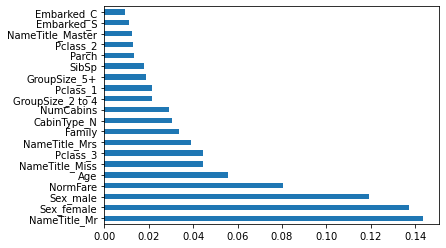

In [592]:
# plot features with the greatest impact on predicting the target using random forest
best_rf = best_clf_rf.best_estimator_.fit(X_train_scaled,y_train)
feat_importances = pd.Series(best_rf.feature_importances_, index=X_train_scaled.columns)
feat_importances.nlargest(20).plot(kind='barh')

# for some models, could consider:
# - fine tuning the features of greater importance
# -- NameTitle, Sex, NormFare, Age, Pclass, Family, CabinType, NumCabins
# - removing the features with little importance
# -- Embarked, TicketLetters, AgeRange

Summary of results:
- svc 83.27%
- rf 82.94% / lr 82.94%
- knn 81.93%

However, beware of overfitting

# Submission 4

Still 77.99% accuracy so no improvement after "fine-tuning" parameters

In [611]:
# model with greatest prediction
best_clf_svc.best_estimator_.fit(X_train_scaled, y_train)
y_hat_svc = best_clf_svc.best_estimator_.predict(X_test_scaled)
svc_submission = {'PassengerId' : test_data.PassengerId, 'Survived' : y_hat_svc}
submission_svc = pd.DataFrame(data=svc_submission)
submission_svc.to_csv('my_submission_4.csv', index=False)

# Submission 5

Still 77.99% accuracy so no improvement after "fine-tuning" parameters

In [612]:
best_clf_rf.best_estimator_.fit(X_train_scaled, y_train)
y_hat_rf = best_clf_rf.best_estimator_.predict(X_test_scaled)
rf_submission = {'PassengerId' : test_data.PassengerId, 'Survived' : y_hat_rf}
submission_rf = pd.DataFrame(data=rf_submission)
submission_rf.to_csv('my_submission_5.csv', index=False)

# Submission 6
Still 77.99% accuracy so no improvement after "fine-tuning" parameters

In [613]:
best_clf_lr.best_estimator_.fit(X_train_scaled, y_train)
y_hat_lr = best_clf_lr.best_estimator_.predict(X_test_scaled)
lr_submission = {'PassengerId' : test_data.PassengerId, 'Survived' : y_hat_lr}
submission_lr = pd.DataFrame(data=lr_submission)
submission_lr.to_csv('my_submission_6.csv', index=False)

# Model Additional Ensemble Approaches

Do another voting classifier with our tuned model
- experiment with hard voting classifier of three estimators (KNN, SVM, RF)
- experiment with soft voting classificer of three estimators (KNN, SVM, RF)
- experiment with soft voting on all estimators performing better than 80% (KNN, RF, LR, SVC)

In [598]:
best_lr = best_clf_lr.best_estimator_
best_knn = best_clf_knn.best_estimator_
best_svc = best_clf_svc.best_estimator_
best_rf = best_clf_rf.best_estimator_

In [599]:
voting_clf_hard = VotingClassifier(estimators=[('knn', best_knn), ('rf', best_rf), ('svc', best_svc)], voting='hard')
voting_clf_soft = VotingClassifier(estimators=[('knn', best_knn), ('rf', best_rf), ('svc', best_svc)], voting='soft')
voting_clf_all = VotingClassifier(estimators=[('knn', best_knn), ('rf', best_rf), ('svc', best_svc), ('lr', best_lr)], voting='soft')

In [600]:
print('voting_clf_hard :', cross_val_score(voting_clf_hard, X_train, y_train, cv=5))
print('voting_clf_hard mean :', cross_val_score(voting_clf_hard, X_train, y_train, cv=5).mean())

voting_clf_hard : [0.80446927 0.8258427  0.80337079 0.79213483 0.82022472]
voting_clf_hard mean : 0.8092084614901764


In [601]:
print('voting_clf_soft :', cross_val_score(voting_clf_soft, X_train, y_train, cv=5))
print('voting_clf_soft mean :', cross_val_score(voting_clf_soft, X_train, y_train, cv=5).mean())

voting_clf_soft : [0.79329609 0.80898876 0.83146067 0.79213483 0.86516854]
voting_clf_soft mean : 0.817079907099366


In [602]:
print('voting_clf_all :', cross_val_score(voting_clf_all, X_train, y_train, cv=5))
print('voting_clf_all mean :', cross_val_score(voting_clf_all, X_train, y_train, cv=5).mean())

voting_clf_all : [0.81005587 0.82022472 0.81460674 0.80337079 0.85393258]
voting_clf_all mean : 0.8215554579122466


In [603]:
# in a soft voting classifier you can weight some models more than others.  Use a grid search to explore different weightings
params = {'weights' : [[1,1,1],[1,2,1],[1,1,2],[2,1,1],[2,2,1],[1,2,2],[2,1,2]]}
vote_weight = GridSearchCV(voting_clf_soft, param_grid = params, cv = 5, verbose = True, n_jobs = None)
best_clf_weight = vote_weight.fit(X_train_scaled,y_train)
clf_performance(best_clf_weight,'VC Weights')
voting_clf_sub = best_clf_weight.best_estimator_.predict(X_test_scaled)

# the result was [1,1,1] i.e. the weighting we had was already optimal

Fitting 5 folds for each of 7 candidates, totalling 35 fits
VC Weights
Best Score: 0.8327851358985624
Best Parameters: {'weights': [1, 1, 1]}


In [604]:
# make predictions 
voting_clf_hard.fit(X_train_scaled, y_train)
voting_clf_soft.fit(X_train_scaled, y_train)
voting_clf_all.fit(X_train_scaled, y_train)

best_rf.fit(X_train_scaled, y_train)
y_hat_vc_hard = voting_clf_hard.predict(X_test_scaled).astype(int)
y_hat_rf = best_rf.predict(X_test_scaled).astype(int)
y_hat_vc_soft =  voting_clf_soft.predict(X_test_scaled).astype(int)
y_hat_vc_all = voting_clf_all.predict(X_test_scaled).astype(int)

In [606]:
#convert output to dataframe 
final_data_7 = {'PassengerId': test_data.PassengerId, 'Survived': y_hat_rf}
submission_7 = pd.DataFrame(data=final_data_7)

final_data_8 = {'PassengerId': test_data.PassengerId, 'Survived': y_hat_vc_hard}
submission_8 = pd.DataFrame(data=final_data_8)

final_data_9 = {'PassengerId': test_data.PassengerId, 'Survived': y_hat_vc_soft}
submission_9 = pd.DataFrame(data=final_data_9)

final_data_10 = {'PassengerId': test_data.PassengerId, 'Survived': y_hat_vc_all}
submission_10 = pd.DataFrame(data=final_data_10)

final_data_comp = {'PassengerId': test_data.PassengerId, 'Survived_vc_hard': y_hat_vc_hard, 'Survived_rf': y_hat_rf, 'Survived_vc_soft' : y_hat_vc_soft, 'Survived_vc_all' : y_hat_vc_all}
comparison = pd.DataFrame(data=final_data_comp)

In [607]:
# track differences between outputs 
comparison['difference_rf_vc_hard'] = comparison.apply(lambda x: 1 if x.Survived_vc_hard != x.Survived_rf else 0, axis =1)
comparison['difference_soft_hard'] = comparison.apply(lambda x: 1 if x.Survived_vc_hard != x.Survived_vc_soft else 0, axis =1)
comparison['difference_hard_all'] = comparison.apply(lambda x: 1 if x.Survived_vc_all != x.Survived_vc_hard else 0, axis =1)

comparison.difference_hard_all.value_counts()

0    405
1     13
Name: difference_hard_all, dtype: int64

In [609]:
# prepare submission files 
submission_7.to_csv('my_submission_7.csv', index =False)    # 78.229%
submission_8.to_csv('my_submission_8.csv',index=False)      # 78.229%
submission_9.to_csv('my_submission_9.csv', index=False)     # 78.229%
submission_10.to_csv('my_submission_10.csv', index=False)   # 77.033%

78.229% is the highest accuracy so far, shared by submissions 7, 8 and 9

Compare this with the standard submission based only on gender (76.55% accuracy) and it's not much of an improvement